## The purpose of this homework is to implement Canny Edge Detector

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib notebook

from skimage.io import imread
from skimage.transform import resize
from tqdm import tqdm

from skimage.color import rgb2gray
from scipy.signal import convolve2d

### As you know from theory, Canny Edge Detection algorithm is composed of 4 steps: 
- Bluring the image to suppress the noise
- Calculation of the gradient and the magnitude of the image-gradient
- Non-maximum suppression
- Hystersis thresholding

#### At first let's read and visualize an image.

In [2]:
img = imread('tree.jpg')/255.
img = resize(img, (240, 320), preserve_range=True)
img = rgb2gray(img)

C:\ProgramData\Anaconda3\lib\site-packages\skimage\transform\_warps.py:105: UserWarning: The default mode, 'constant', will be changed to 'reflect' in skimage 0.15.
  warn("The default mode, 'constant', will be changed to 'reflect' in "
C:\ProgramData\Anaconda3\lib\site-packages\skimage\transform\_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


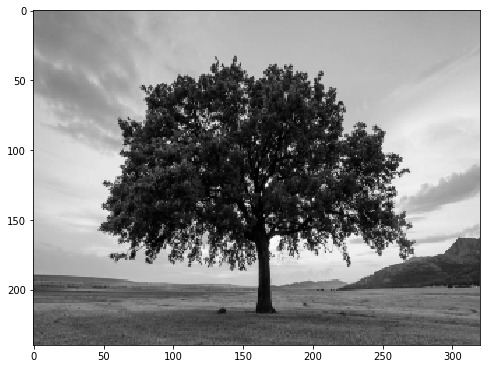

In [3]:
plt.figure(figsize=(8, 8))
plt.imshow(img, cmap = 'gray')

In order to suppress the noise in the image, we apply bluring.

### Step 1: Gaussian blur

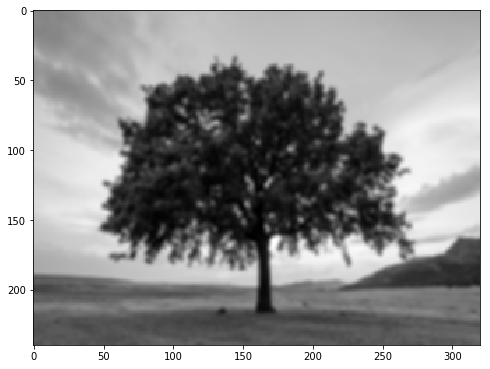

In [4]:
kernel_size = 5
sigma = 1.4

size = int(kernel_size) // 2
x, y = np.mgrid[-size:size+1, -size:size+1]
normal = 1 / (2.0 * np.pi * sigma**2)
gaussian_kernel =  np.exp(-((x**2 + y**2) / (2.0*sigma**2))) * normal

smooth_img = convolve2d(img, gaussian_kernel, boundary='symm', mode='same') # TODO get gaussian blured image with some sigma and kernel size
plt.figure(figsize=(8, 8))
plt.imshow(smooth_img, cmap = 'gray')
plt.show()

### Step 2: Gradient Calculation

In [5]:
Kx = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], np.float32)
Ky = np.array([[1, 2, 1], [0, 0, 0], [-1, -2, -1]], np.float32)
G_x, G_y = convolve2d(img, Kx, boundary='symm', mode='same'), convolve2d(img, Ky, boundary='symm', mode='same') # TODO Calculate the gradient of the image
M = np.hypot(G_x, G_y) # TODO Compute the magnitude of the image gradient
M = M/M.max()

### Step 3: Non-Maximum Suppression

#### Note !!! for implementation of non-maximum suppression you can follow the following steps, but your own implementation is also applicable.

Defining four directions

In [6]:
d_x = (1, 1/np.sqrt(2), 0, 1/np.sqrt(2))
d_y = (0, 1/np.sqrt(2), 1, -1/np.sqrt(2))
D = np.array([[d_x[i], d_y[i]] for i in range(4)])

In [7]:
from sklearn.metrics.pairwise import cosine_similarity

def min_index(pixel):
    """
    Closest direction calculation
    -----------
    Parameters:
        pixel (tuple or 1d array)
    Returns:
        int (index of closest direction on D directions array)
    """
    temp = []
    for i in range(4):
        temp.append(cosine_similarity([D[i]], [pixel])[0, 0])
    return np.argmax(temp)

In [8]:
# TODO Obtain a matrix of shape (img.shape[0], img.shape[1]), 
# for which A[i,j] is the number of the closest direction from D in the point (i,j). 
# For example, if the direction D[1,:] is the closest to the gradient of the image in the point (i,j), 
# i.e. G[i,j,:], then A[i,j] = 1.

In [9]:
A = np.zeros((smooth_img.shape[0], smooth_img.shape[1]))
for i in tqdm(range(smooth_img.shape[0])):
    for j in range(smooth_img.shape[1]):
        A[i, j] = min_index([G_x[i, j], G_y[i, j]])
A = A.astype(int)

100%|████████████████████████████████████████████████████████████████████████████████| 240/240 [01:53<00:00,  2.13it/s]


In [10]:
res = np.zeros((smooth_img.shape[0], smooth_img.shape[1]))
M_pad = np.zeros((smooth_img.shape[0]+2, smooth_img.shape[1]+2))
M_pad[1:-1,1:-1] = M.copy()
for i in tqdm(range(smooth_img.shape[0])):
    for j in range(smooth_img.shape[1]):
        tq = min_index(D[A[i, j]])
        if tq == 0: #0 is E-W (horizontal)
            M_p = M_pad[i+1, j]
            M_n = M_pad[i+1, j+2]
        if tq == 1: #1 is NE-SW
            M_p = M_pad[i, j+2]
            M_n = M_pad[i+2, j]
        if tq == 2: #2 is N-S (vertical)
            M_p = M_pad[i, j+1]
            M_n = M_pad[i+2, j+1]
        if tq == 3: #3 is NW-SE
            M_p = M_pad[i, j]
            M_n = M_pad[i+2, j+2]
            
        if M_pad[i,j] >= M_p and M_pad[i,j] >= M_n:
            res[i,j] = M_pad[i,j]

100%|████████████████████████████████████████████████████████████████████████████████| 240/240 [01:47<00:00,  2.26it/s]


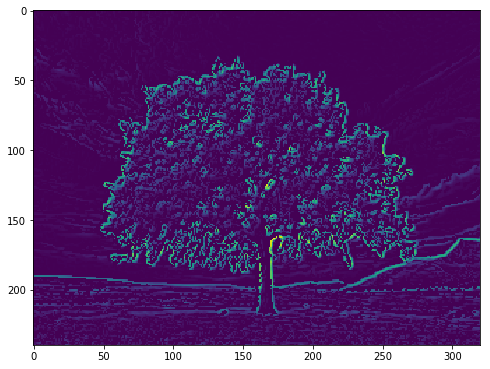

In [11]:
plt.figure(figsize=(8, 8))
plt.imshow(res)

### Step 4: Hystersis Thresholding

In [12]:
def hysteresis(img, highThreshold, lowThreshold):
    WEAK = 0.3
    STRONG = 1.
    M, N = img.shape

    def threshold(img, highThreshold, lowThreshold):
        M, N = img.shape
        highThreshold = img.max() * highThreshold;
        lowThreshold = highThreshold * lowThreshold;

        res = np.zeros((M,N), dtype=np.int32)

        strong_i, strong_j = np.where(img >= highThreshold)
        zeros_i, zeros_j = np.where(img < lowThreshold)

        weak_i, weak_j = np.where((img <= highThreshold) & (img >= lowThreshold))

        res[strong_i, strong_j] = STRONG
        res[weak_i, weak_j] = WEAK

        return (res)
    
    img = threshold(img, highThreshold, lowThreshold)

    for i in range(1, M-1):
        for j in range(1, N-1):
            if (img[i,j] == WEAK):
                try:
                    if ((img[i+1, j-1] == STRONG) or (img[i+1, j] == STRONG) or (img[i+1, j+1] == STRONG)
                        or (img[i, j-1] == STRONG) or (img[i, j+1] == STRONG)
                        or (img[i-1, j-1] == STRONG) or (img[i-1, j] == STRONG) or (img[i-1, j+1] == STRONG)):
                        img[i, j] = STRONG
                    else:
                        img[i, j] = 0
                except IndexError as e:
                    pass
    return img

In [13]:
can_res = hysteresis(res, 0.2, 0.05)

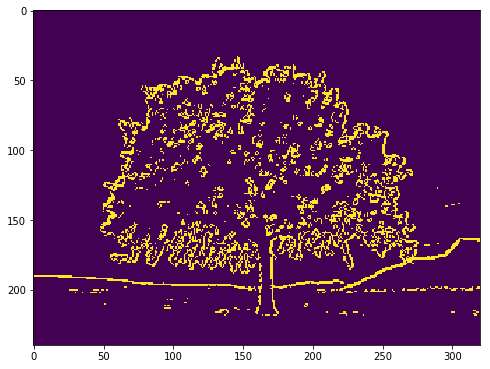

In [14]:
plt.figure(figsize=(8, 8))
plt.imshow(can_res)